Now in 5_2 versions I am going to try the model with augmented datasets which I have created in the file dataset_gen.ipynb and stored doing pickling. Here I am going to load the pickled files only and test out the model.


In [1]:
import pandas as pd

In [2]:
import torch, torchtext
from torchtext import data

Here I am going to load the pickled files


In [3]:
from google.colab import files
uploaded=files.upload()

Saving trainset_new.pkl to trainset_new (1).pkl


In [4]:
import os, pickle

In [5]:
f1=open('trainset_new.pkl','rb')
tr_set=pickle.load(f1)
f1.close()

In [6]:
import random
import torch, torchtext
from torchtext import data

In [7]:
#Review
Review_text= torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [8]:
fields = [('review',Review_text),('label',Label)]

In [9]:
train_set=torchtext.legacy.data.Dataset(tr_set,fields)

In [10]:
len(train_set)

10225

In [11]:
uploaded=files.upload()
f1=open('testset.pkl','rb')
ts_set=pickle.load(f1)
f1.close()

Saving testset.pkl to testset (1).pkl


In [12]:
uploaded=files.upload()
f1=open('valset.pkl','rb')
vl_set=pickle.load(f1)
f1.close()

Saving valset.pkl to valset (1).pkl


In [13]:
#train_example = [torchtext.legacy.data.Example.fromlist([df.text[i],df.label[i]], fields) for i in range(df.shape[0])] 

In [14]:
#train_set=torchtext.legacy.data.Dataset(train_example,fields)

In [15]:
test_set=torchtext.legacy.data.Dataset(ts_set,fields)
val_set=torchtext.legacy.data.Dataset(vl_set,fields)

In [16]:
#test_example = [torchtext.legacy.data.Example.fromlist([test_set.text[i],test_set.label[i]], fields) for i in range(test_set.shape[0])] 
#val_example = [torchtext.legacy.data.Example.fromlist([val_set.text[i],val_set.label[i]], fields) for i in range(val_set.shape[0])] 

In [17]:
len(train_set),len(test_set),len(val_set)

(10225, 2210, 1101)

In [18]:
Review_text.build_vocab(train_set)
Label.build_vocab(train_set)

In [19]:
print('Size of input vocab : ', len(Review_text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Review_text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  18489
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 9418), (',', 8453), ('the', 7353), ('and', 5438), ('of', 5280), ('a', 5189), ('to', 3579), ('is', 3188), ('-', 3102), ("'s", 2772)]
Labels :  defaultdict(None, {'4': 0, '2': 1, '5': 2, '3': 3, '1': 4})


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
train_iterator = torchtext.legacy.data.BucketIterator(train_set, batch_size = 64, shuffle=True, device=device)
#                                                           sort_key = lambda x: len(x.review),
#                                                           sort_within_batch=True, device = device)

In [22]:
valid_iterator = torchtext.legacy.data.BucketIterator(val_set, batch_size = 64, shuffle=True, device=device)
#                                                            sort_key = lambda x: len(x.review),
#                                                           sort_within_batch=True, device = device)

In [23]:
test_iterator = torchtext.legacy.data.BucketIterator(test_set, batch_size = 64, shuffle=True, device=device)
#                                                            sort_key = lambda x: len(x.review),
#                                                            sort_within_batch=True, device = device)

In [24]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    #pickle.dump(Tweet.vocab.stoi, tokens)
    pickle.dump(Review_text.vocab.stoi,tokens)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super(classifier,self).__init__()   
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.output_dim=output_dim
        self.n_layers=n_layers       
        self.directions=2
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.GRU(embedding_dim, 
                           hidden_dim, 
                           n_layers, 
                           #dropout=dropout,
                           batch_first=True,bidirectional=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        batch_size=text.size(0)
        next=self.n_layers*2
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        #hidden=torch.zeros(next,self.hidden_dim).to(device)
        packed_output_f, hidden= self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        #dense_outputs = self.fc(packed_output_f[:,-1,:]) 
        dense_outputs = self.fc(hidden)     
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [26]:
# Define hyperparameters
size_of_vocab=len(Review_text.vocab)
embedding_dim = 500
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [27]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(18489, 500)
  (encoder): GRU(500, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 9,787,405 trainable parameters


In [28]:
device

device(type='cuda')

In [29]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def cat_accuracy(preds,y):
    top_pred=preds.argmax(1,keepdim=True)
    correct=top_pred.eq(y.view_as(top_pred)).sum()
    acc=correct.float()/y.shape[0]
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [30]:
b=next(iter(train_iterator))
review,review_length=b.review
    


In [31]:
predictions=model(review,review_length)
predictions.shape

optimizer.zero_grad()
loss = criterion(predictions, b.label)   
L2_lambda=0.001
L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
loss=loss+L2_lambda*L2_norm     
acc = cat_accuracy(predictions, b.label)   
loss.backward()       
optimizer.step()  

In [32]:
loss.item()

9248.787109375

In [33]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        #tweet, tweet_lengths = batch.tweet  
        review,review_length = batch.review
        
        # convert to 1D tensor
        #predictions = model(tweet, tweet_lengths).squeeze()  
        predictions=model(review,review_length)
        
        # compute the loss
        loss = criterion(predictions, batch.label)    
        #adding regularization
        L2_lambda=0.001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
        loss=loss+L2_lambda*L2_norm
        
        # compute the categorical accuracy
        acc = cat_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            #tweet, tweet_lengths = batch.tweet
            review,review_length = batch.review
            
            # convert to 1d tensor
            predictions = model(review, review_length).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = cat_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
device

device(type='cuda')

In [36]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import numpy as np

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf')
global plot_iter, plot_loss_train, plot_loss_val
plot_iter = np.zeros((0))
plot_loss_train = np.zeros((0))
plot_loss_val = np.zeros((0))
plot_loss_test=np.zeros((0))
for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    # evaluate the model on test data
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc=valid_acc
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\t epoch : {epoch} |\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')
    plot_iter = np.append(plot_iter, [epoch])
    plot_loss_train = np.append(plot_loss_train, [train_loss])
    plot_loss_val = np.append(plot_loss_val, [valid_loss])
print(f'\Best Valid Accuracy :{best_valid_acc*100:.2f}\n')


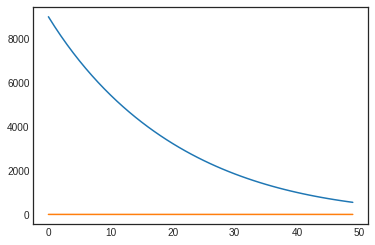

In [38]:
plt.plot(plot_iter, plot_loss_train, plot_loss_val)
display.clear_output(wait=True)
plt.show()

In [39]:
test_iterator = torchtext.legacy.data.BucketIterator(test_set, batch_size = 10, shuffle=True) 
                                          

In [40]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_review(t):
    
    categories = {0: "Positive",1:"Negative", 2:"Neutral", 3:"Very Positive", 4:"Very Negative"}
    
  
    tokenized = [tok.text for tok in nlp.tokenizer(t)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    #print(prediction)
    #print(prediction.max())
    #print(categories)
    _, pred = torch.max(prediction, 1) 
    #print(pred.item()) 
    return categories[pred.item()]

In [ ]:
uploaded=files.upload()

In [ ]:
f1=open('test_sent.pkl','rb')
tst=pickle.load(f1)
f1.close()

In [ ]:
import random
random.seed(43)

In [ ]:
r_n=random.choice(tst)

In [ ]:
print(r_n)

In [ ]:


for i in range(10):
  r_n=random.choice(tst)
  #print(r_n)
  p=classify_review(r_n)
  print(f'{r_n} | sentiment : {p}')